In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP
import os
import pickle

In [9]:
from keras import Input
from keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

In [10]:
X_data = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/10Topics/X_data.pkl', 'rb'))
y_data = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/10Topics/y_data.pkl', 'rb'))

X_test = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/10Topics/X_test.pkl', 'rb'))
y_test = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/10Topics/y_test.pkl', 'rb'))



In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_data) # learn vocabulary and idf from training set
X_data_tfidf =  tfidf_vect.transform(X_data)
# assume that we don't have test set before
X_test_tfidf =  tfidf_vect.transform(X_test)

In [12]:
tfidf_vect.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aaa',
 'aac',
 'aachen',
 'aaron',
 'aas',
 'ab',
 'aba',
 'abashidze',
 'abba',
 'abbas',
 'abbey',
 'abbiati',
 'abbondanzieri',
 'abbott',
 'abc',
 'abd',
 'abdel',
 'abdelrahim',
 'abdoulaye',
 'abdul',
 'abdulaziz',
 'abdullah',
 'abe',
 'abel',
 'aberdeen',
 'abeyie',
 'abf',
 'abidjan',
 'abkhazia',
 'able',
 'abn',
 'about',
 'abqaiq',
 'abraham',
 'abramoff',
 'abramovich',
 'abs',
 'abtc',
 'abu',
 'ac',
 'academy',
 'acasiete',
 'acb',
 'acbs',
 'accc',
 'accept',
 'access',
 'account',
 'accumbens',
 'ace',
 'aceh',
 'acer',
 'acetaminophen',
 'achilefu',
 'achilles',
 'acid',
 'acid_amin',
 'acid_béo',
 'acl',
 'acm',
 'acoo',
 'acpe',
 'acrobat',
 'acronis',
 'acropolis',
 'acrylic',
 'act',
 'action',
 'active',
 'activex',
 'acuff',
 'acyclovir',
 'ad',
 'adam',
 'adams',
 'adan',
 'adani',
 'adapter',
 'adb',
 'add',
 'address',
 'addvote',
 'adebayor',
 'adelaide',
 'adelman',
 'aden',
 'adeno',
 'adeportivo',
 'adidas',
 'adler',
 'admin',
 'adn',
 'adnan',


In [13]:
from sklearn.decomposition import TruncatedSVD

In [14]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_data_tfidf)

TruncatedSVD(n_components=300, random_state=42)

In [15]:
X_data_tfidf_svd = svd.transform(X_data_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

In [16]:
from sklearn import preprocessing, metrics
encoder = preprocessing.LabelEncoder()
y_data_n = encoder.fit_transform(y_data)
y_test_n = encoder.fit_transform(y_test)

encoder.classes_

array(['Chinh tri Xa hoi', 'Doi song', 'Khoa hoc', 'Kinh doanh',
       'Phap luat', 'Suc khoe', 'The gioi', 'The thao', 'Van hoa',
       'Vi tinh'], dtype='<U16')

In [17]:
def plot_model_history(model_history, acc='accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train'], loc='best')
    plt.show()

In [18]:
epochs=50
learning_rate=0.001

In [19]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [20]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.9)

In [21]:
adam = Adam(learning_rate=learning_rate)

In [22]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve, classification_report, auc

In [23]:
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True, fmt='g')
    print(cmx_data)
    plt.show()

In [24]:
def create_dnn_model():
    input_layer = Input(shape=(300,))
    layer = Dense(1024, activation='relu')(input_layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)
    output_layer = Dense(10, activation='softmax')(layer)
    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

In [25]:
def train_model(classifier, X_data, y_data, X_test, y_test, is_neuralnet=False, epochs=epochs):       
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
    
    model_history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32, callbacks=[earlystopping])
    
    val_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(X_test)
    val_predictions = val_predictions.argmax(axis=-1)
    test_predictions = test_predictions.argmax(axis=-1)
        
    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))
    plot_model_history(model_history)
    
    target_names = ["Class {}".format(i) for i in range(10)]
    print(classification_report(test_predictions, y_test, target_names=target_names, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
    print_cmx(test_predictions, y_test)

In [26]:
classifier=create_dnn_model()

Epoch 1/50
950/950 [==============================] - 7s 4ms/step - loss: 0.4269 - accuracy: 0.8674 - val_loss: 0.3462 - val_accuracy: 0.8883
Epoch 2/50
950/950 [==============================] - 4s 4ms/step - loss: 0.3015 - accuracy: 0.9034 - val_loss: 0.3048 - val_accuracy: 0.9031
Epoch 3/50
950/950 [==============================] - 4s 4ms/step - loss: 0.2509 - accuracy: 0.9183 - val_loss: 0.3126 - val_accuracy: 0.9052
Epoch 4/50
950/950 [==============================] - 4s 4ms/step - loss: 0.2080 - accuracy: 0.9325 - val_loss: 0.3298 - val_accuracy: 0.8981
Epoch 5/50
950/950 [==============================] - 4s 4ms/step - loss: 0.1625 - accuracy: 0.9479 - val_loss: 0.3317 - val_accuracy: 0.9005
Epoch 6/50
950/950 [==============================] - 4s 4ms/step - loss: 0.1243 - accuracy: 0.9610 - val_loss: 0.3824 - val_accuracy: 0.8960
Epoch 7/50
950/950 [==============================] - 4s 4ms/step - loss: 0.0976 - accuracy: 0.9689 - val_loss: 0.4050 - val_accuracy: 0.8945
Epoch 

<ipython-input-17-54089400f08a>:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
<ipython-input-17-54089400f08a>:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)


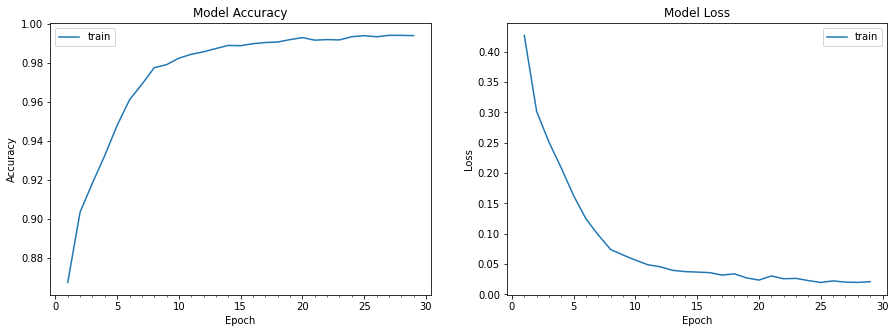

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

     Class 0       0.64      0.67      0.66      1958
     Class 1       0.76      0.80      0.78      1977
     Class 2       0.87      0.92      0.89      4993
     Class 3       0.90      0.90      0.90      3827
     Class 4       0.93      0.93      0.93      5414
     Class 5       0.90      0.96      0.93      6291
     Class 6       0.98      0.98      0.98      6626
     Class 7       0.96      0.87      0.91      6849
     Class 8       0.95      0.92      0.94      4689
     Class 9       0.00      0.00      0.00         0

   micro avg       0.91      0.91      0.91     42624
   macro avg       0.79      0.79      0.79     42624
weighted avg       0.91      0.91      0.91     42624

[[6538  170   88  353  224   97  138   15   81   45]
 [ 140 1310  118   47   33   91   78   38   77   26]
 [  62   74 1585   28    2   94   83    3   16   30]
 [ 157   19   17 4587   37   24   75    2   32   43]
 [ 240   17    1   52 3426   

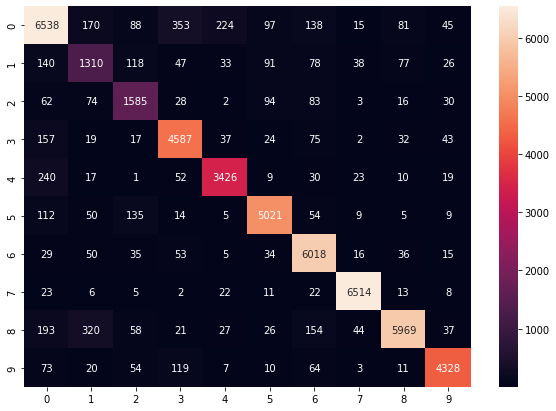

In [27]:
train_model(classifier=classifier, X_data=X_data_tfidf_svd, y_data=y_data_n, X_test=X_test_tfidf_svd, y_test=y_test_n)